Test HA perfomance with inference time

In [ ]:
import os
import cv2
import numpy as np
import joblib
import torch
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, recall_score, f1_score
from tensorflow.keras.applications import DenseNet169, VGG19, EfficientNetB2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
from sklearn.model_selection import train_test_split
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from tensorflow.keras.layers import Dense, Multiply
import time


def create_model(base_model, input_shape, dropout_rate=0.4):
    base = base_model(weights="imagenet", include_top=False, input_tensor=Input(shape=input_shape))
    x = GlobalAveragePooling2D()(base.output)  
    return Model(inputs=base.input, outputs=x)



def extract_features_in_batches(model, images, batch_size=32):
    return model.predict(images, batch_size=batch_size, verbose=0)


def preprocess_image_tf(image_path, img_size=(224, 224)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, img_size)
    img = img / 255.0 
    img = np.expand_dims(img, axis=0)  
    return img.astype(np.float32)

# === Load Models ===
input_shape = (224, 224, 3)
model_DenseNet169 = create_model(DenseNet169, input_shape)
model_VGG19 = create_model(VGG19, input_shape)
model_EfficientNetB2 = create_model(EfficientNetB2, input_shape)

best_svm = joblib.load("M1_svm.pkl")  


class ECALayer(nn.Module):
    def __init__(self, channel, gamma=2, b=1):
        super().__init__()
        t = int(abs((torch.log(torch.tensor(channel, dtype=torch.float32)) / torch.log(torch.tensor(2.0))) + b) / gamma)
        k = t if t % 2 else t + 1
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k, padding=(k - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv(y.squeeze(-1).transpose(-1, -2))
        y = self.sigmoid(y).transpose(-1, -2).unsqueeze(-1)
        return x * y.expand_as(x)

class CropDiseaseModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = models.resnet50(pretrained=True)
        self.backbone.fc = nn.Identity()
        self.eca = ECALayer(channel=2048)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), 2048, 1, 1)
        x = self.eca(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)

model2 = CropDiseaseModel(num_classes=9)
model2.load_state_dict(torch.load("M2_ECA.pth", map_location=torch.device("cpu")))
model2.eval()

transform_torch = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.CenterCrop((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


dataset_path = "PFE_dataset" # this dataset contain all the classes healthy and all other diseases
classes = ["Healthy"] + sorted([c for c in os.listdir(dataset_path) if c != "Healthy"])
label_map = {cls: idx for idx, cls in enumerate(classes)}

image_paths = []
labels = []

for cls in classes:
    cls_folder = os.path.join(dataset_path, cls)
    for fname in os.listdir(cls_folder):
        if fname.lower().endswith((".jpg", ".png", ".jpeg")):
            image_paths.append(os.path.join(cls_folder, fname))
            labels.append(label_map[cls])

train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42, stratify=labels)

# === Evaluation with Timing ===
y_true = []
y_pred = []
total_inference_time = 0.0

for img_path, true_label in zip(test_paths, test_labels):
    try:
        start_time = time.time() 
        image_tf = preprocess_image_tf(img_path)

        features = np.concatenate([
             extract_features_in_batches(model_DenseNet169, image_tf),
             extract_features_in_batches(model_VGG19, image_tf),
             extract_features_in_batches(model_EfficientNetB2, image_tf),
        ], axis=1)

        pred_m1 = best_svm.predict(features)[0]

        if pred_m1 == 0: 
            final_pred = label_map["Healthy"]
        else:
           
            image_pil = Image.open(img_path).convert("RGB")
            input_tensor = transform_torch(image_pil).unsqueeze(0)
            with torch.no_grad():
                output = model2(input_tensor)
                probs = torch.nn.functional.softmax(output, dim=1)
                pred_label = torch.argmax(probs).item()
                final_pred = pred_label + 1 

        end_time = time.time()  
        inference_time = end_time - start_time
        total_inference_time += inference_time

        y_true.append(true_label)
        y_pred.append(final_pred)

    except Exception as e:
        print(f"❌ Failed to process image: {img_path} | Error: {e}")

# === Metrics ===
acc = accuracy_score(y_true, y_pred)
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
avg_time = total_inference_time / len(y_true) if y_true else 0

print("\n✅ Evaluation Metrics on Test Set:")
print(f"Accuracy: {acc:.4f}")
print(f"Recall:   {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

c:\Users\DELL\intelpython3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DELL\intelpython3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\DELL\intelpython3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_9715']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
c:\Users\DELL\intelpython3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure 


✅ Evaluation Metrics on Test Set:
Accuracy: 0.9948
Recall:   0.9953
F1 Score: 0.9950


In [19]:
print(f"\n⏱️ Total Inference Time: {total_inference_time:.4f} seconds")
print(f"⏱️ Average Inference Time per Image: {avg_time:.4f} seconds")


⏱️ Total Inference Time: 615.5830 seconds
⏱️ Average Inference Time per Image: 0.8047 seconds


<Figure size 1000x1000 with 0 Axes>

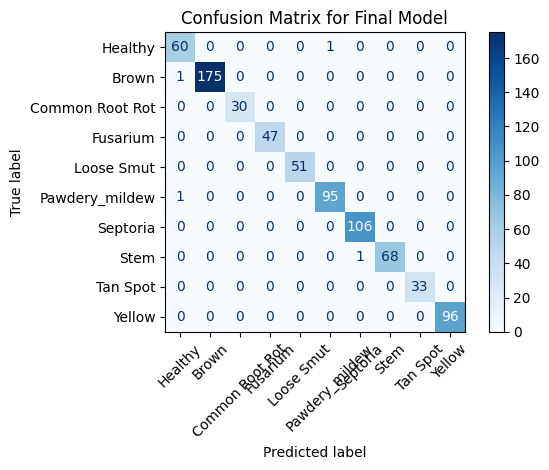

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

plt.figure(figsize=(10, 10))
disp.plot(cmap='Blues', xticks_rotation=45) 
plt.title("Confusion Matrix for Final Model")
plt.tight_layout()
plt.show()
